This notebook aims to test out how well the new numerical scheme from Julia is implemented in OGGM.

For this notebook to work, downloading the OGGM version available at : https://github.com/lucillegimenes/oggm is necessary. 

In [1]:
# %%
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks
from oggm.core import flowline, massbalance
import salem
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import functools
from oggm.shop import gcm_climate
import time

cfg.initialize(logging_level='WARNING')

cfg.PARAMS['use_multiprocessing'] = False
cfg.PATHS['working_dir'] = '/home/gimenelu/Run_oggm_test/'
cfg.PARAMS['continue_on_error'] = True

2023-09-27 15:40:43: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-09-27 15:40:43: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-09-27 15:40:43: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-09-27 15:40:43: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [ ]:
#Choosing one glacier
rgi_id = ['RGI60-15.03733'] #Mer de Glace
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_spinup/'
gdirs = workflow.init_glacier_directories(rgi_id, from_prepro_level=4, prepro_base_url=base_url, prepro_border=160)
gdir=gdirs[0]

workflow.execute_entity_task(tasks.init_present_time_glacier,gdirs);

In [ ]:
gdir

In [ ]:
#Climate data to use for later
user ='gimenelu'
m='MRI-ESM2-0'
ssp='ssp126'

fp = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6/pr/{}_{}_r1i1p1f1_pr.nc'.format(user,m,ssp)
ft = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6/tas/{}_{}_r1i1p1f1_tas.nc'.format(user,m,ssp)

#Bias correction of the files
workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, 
                                         filesuffix='_CMIP6_{}_{}'.format(m,ssp),  # recognize the climate file for later
                                         fpath_temp=ft,  # temperature projections
                                         fpath_precip=fp,  # precip projections
                                         );

## Random climate simulation

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit"

In [ ]:
%%time
workflow.execute_entity_task(tasks.run_random_climate,gdirs,y0=2003,nyears=300,seed=1,
                                         output_filesuffix='_semi')

In [ ]:
ds = utils.compile_run_output(gdirs, input_filesuffix='_semi')

In [ ]:
# The only thing to do to use the new Julia iceflow model is to specify its name in configuration parameters
cfg.PARAMS["evolution_model"] = "SIA1D" 

In [ ]:
#If wanting to change the Julia solver
from juliacall import Main as jl
jl.seval("using OrdinaryDiffEq")
jl.seval("using LinearSolve")
cfg.PARAMS["Julia_solver"] = jl.ImplicitEuler() 

In [ ]:
%%time
workflow.execute_entity_task(tasks.run_random_climate,gdirs,y0=2003,nyears=300,seed=1,
                                         output_filesuffix='_julia')

In [ ]:
ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

## Constant climate

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit"

workflow.execute_entity_task(tasks.run_constant_climate,gdir,y0=1916,nyears=100,
                                         output_filesuffix='_semi',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)

ds = utils.compile_run_output(gdir, input_filesuffix='_semi')

In [ ]:
cfg.PARAMS["evolution_model"] = "SIA1D"

workflow.execute_entity_task(tasks.run_constant_climate,gdir,y0=1916,nyears=100,
                                         output_filesuffix='_julia',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)

ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

## GCM climate data

In [ ]:
%%time
cfg.PARAMS["evolution_model"] = "SemiImplicit"        
    
sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_semi',
                                         init_model_filesuffix='_spinup_historical')
ds = utils.compile_run_output(gdir, input_filesuffix='_semi')

In [ ]:
%%time
cfg.PARAMS["evolution_model"] = "SIA1D"    
    
sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_julia',
                                         init_model_filesuffix='_spinup_historical')
ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

## Testing spinup

### 1. Fixed geometry 

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit" 

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,fixed_geometry_spinup_yr=1990, ye=2100,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_hist_fixed_geom',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_hist_fixed_geom')) as ds:
    ds = ds.load()

In [ ]:
cfg.PARAMS["evolution_model"] = "SIA1D" 

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,fixed_geometry_spinup_yr=1950, ye=2050,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_hist_fixed_geom_jl')

# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_hist_fixed_geom_jl')) as ds2:
    ds2 = ds2.load()

### 2. Dynamic spinup alone, matching area

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit" 

In [ ]:
# ---- Second the dynamic spinup alone, matching area ----
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=1979,  # When to start the spinup
                         minimise_for='area',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_area',  # Where to write the output
                         ye=2020)


In [ ]:
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_area')) as ds:
    ds = ds.load()

In [ ]:
cfg.PARAMS["evolution_model"] = "SIA1D" 

In [ ]:
# ---- Second the dynamic spinup alone, matching area ----
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=1979,  # When to start the spinup
                         minimise_for='area',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_area_jl',
                        ye=2020)  # Where to write the output

In [ ]:
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_area_jl')) as ds2:
    ds2 = ds2.load()

### 3. Dynamic spinup alone, matching volume

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit" 
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=1979,  # When to start the spinup
                         minimise_for='volume',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_volume',  # Where to write the output
                         ye=2020)
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_volume')) as ds:
    ds = ds.load()


In [ ]:
cfg.PARAMS["evolution_model"] = "SIA1D" 
# ---- Second the dynamic spinup alone, matching area ----
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=1979,  # When to start the spinup
                         minimise_for='volume',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_vol_jl',
                        ye=2020)  # Where to write the output


# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_vol_jl')) as ds2:
    ds2 = ds2.load()

In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 10),sharex=True)


(ds.volume_m3*1e-9).plot(ax=ax1,label="SemiImplicit")
(ds2.volume_m3*1e-9).plot(ax=ax1,linestyle="dashed",label="SIA_1D")

(ds.area_m2*1e-6).plot(ax=ax2,)
(ds2.area_m2*1e-6).plot(ax=ax2,linestyle='dashed')


(ds.length_m*1e-3).plot(ax=ax3)
(ds2.length_m*1e-3).plot(ax=ax3,linestyle="dashed")

ax1.grid()
ax1.set_ylabel('volume [km3]')
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('area [km2]')
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
ax3.set_ylabel('length [km]')
ax3.set_title('')
ax1.legend()

ax1.set_title('Matching area dynamic spin-up')

## Testing with hydro

In [ ]:
cfg.PARAMS['store_model_geometry'] = True
cfg.PARAMS["evolution_model"] = "SemiImplicit"

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_with_hydro,gdirs,run_task=tasks.run_from_climate_data,
                                         ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_semi',
                                         store_monthly_hydro=True,
                                         store_model_geometry=True,
                                         store_fl_diagnostics=True,
                                            init_model_filesuffix='_spinup_historical');

ds = utils.compile_run_output(gdir, input_filesuffix='_semi')

In [ ]:
cfg.PARAMS['store_model_geometry'] = True
cfg.PARAMS["evolution_model"] = "SIA1D"

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_with_hydro,gdirs,run_task=tasks.run_from_climate_data,
                                         ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_julia',
                                         store_monthly_hydro=True, # recognize the run for later
                                        store_model_geometry=True,
                                         store_fl_diagnostics=True,
                            init_model_filesuffix='_spinup_historical');

ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(12, 8),sharex=True)


runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
ds_runoff = ds[runoff_vars].clip(0) * 1e-9 #convert to Mt
ds_runoff['runoff_Mt']=ds_runoff['melt_on_glacier']+ds_runoff['melt_off_glacier']+ds_runoff['liq_prcp_off_glacier']+ds_runoff['liq_prcp_on_glacier']

ds_runoff['runoff_Mt'].rolling(time=30,center=True,min_periods=1).mean().plot(ax=ax1,label='SemiImplicit')

ds2_runoff = ds2[runoff_vars].clip(0) * 1e-9 #convert to Mt
ds2_runoff['runoff_Mt']=ds2_runoff['melt_on_glacier']+ds2_runoff['melt_off_glacier']+ds2_runoff['liq_prcp_off_glacier']+ds2_runoff['liq_prcp_on_glacier']

ds2_runoff['runoff_Mt'].rolling(time=30,center=True,min_periods=1).mean().plot(ax=ax1,linestyle='dashed',
                                                                               label='Julia')

ax1.set_title(''+gdir.name+' (rolling mean of 30 years)',fontsize=14)

#ax1.set_xlim([2020,2100])
ax1.set_ylabel('Runoff [Mt]',fontsize=14)
ax1.set_xlabel('Time',fontsize=14)
ax1.grid(visible=True)
ax1.set_xlim([2020,2300])

# Plotting results of climate simulation (random, constant or GCM data)

In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 10),sharex=True)

(ds.volume*1e-9).plot(ax=ax1,label="SemiImplicit")
(ds2.volume*1e-9).plot(ax=ax1,linestyle="dashed",label="SIA_1D")

(ds.area*1e-6).plot(ax=ax2)
(ds2.area*1e-6).plot(ax=ax2,linestyle='dashed')


(ds.length*1e-3).plot(ax=ax3)
(ds2.length*1e-3).plot(ax=ax3,linestyle="dashed")

ax1.grid()
ax1.set_ylabel('volume [km3]')
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('area [km2]')
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
ax3.set_ylabel('length [km]')
ax3.set_title('')
ax1.legend()
#ax1.set_xlim([2020,2300])
ax1.set_title('Simulation based on GCM climate data ({})'.format(gdir.rgi_id))

# Checking the geometry files

In [ ]:
with xr.open_dataset(gdir.get_filepath('model_geometry',filesuffix='_julia'),group="fl_0") as dj:
    dj = dj.load()
with xr.open_dataset(gdir.get_filepath('model_geometry',filesuffix='_semi'),group="fl_0") as do:
    do = do.load()

In [ ]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix='_semi'),group="fl_0") as flj:
    flj = flj.load()
with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix='_julia'),group="fl_0") as flo:
    flo = flo.load()

In [ ]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").volume_m3*1e-9 ,label='vol Julia')
plt.plot(flo.mean(dim="time").volume_m3*1e-9,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('volume [km3]')

plt.grid()
plt.legend()

In [ ]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").area_m2*1e-6 ,label='vol Julia')
plt.plot(flo.mean(dim="time").area_m2*1e-6,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('area [km2]')


plt.grid()
plt.legend()

In [ ]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").area_m2*1e-6 ,label='vol Julia')
plt.plot(flo.mean(dim="time").area_m2*1e-6,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('area [km2]')


plt.grid()
plt.legend()

In [ ]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").ice_velocity_myr ,label='vol Julia')
plt.plot(flo.mean(dim="time").ice_velocity_myr,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('ice_velocity_myr')


plt.grid()
plt.legend()

In [ ]:
f= plt.subplots(figsize=(12, 10))


plt.plot(flj.dis_along_flowline,flj.bed_h,label='bed',color='k')
plt.plot(flo.dis_along_flowline,flo.bed_h + flo.thickness_m[-1] ,label='surface SemiImplicit')
plt.plot(flj.dis_along_flowline,flj.bed_h + flj.thickness_m[-1] ,label='surface SIA_1D', linestyle='dashed')


plt.plot(flo.dis_along_flowline,flo.bed_h + flo.thickness_m[0] ,label='surface initiale oggm')
plt.ylabel('Elevation [m]')
plt.xlabel('Distance along flowline [m]')
plt.title('Glacier profile at the end of GCM data run')

plt.grid()
plt.legend()


In [ ]:
np.mean((dj.mean(dim="x").ts_section - do.mean(dim="x").ts_section)*1e-6)

In [ ]:
plt.plot((dj.mean(dim="x").ts_section - do.mean(dim="x").ts_section)*1e-6)
plt.ylabel('ts_section [km2]')
plt.grid()

In [ ]:
np.mean((dj.mean(dim="x").ts_width_m - do.mean(dim="x").ts_width_m)*1e-3)

In [ ]:
plt.plot((dj.mean(dim="x").ts_width_m - do.mean(dim="x").ts_width_m)*1e-3)
plt.ylabel('ts_width [km]')
plt.grid()

In [ ]:
do.isel(x=50).ts_section.plot(label='SemiImp')
dj.isel(x=50).ts_section.plot(label='Julia',linestyle='dashed')
plt.legend()
plt.grid()

In [ ]:
do.isel(x=100).ts_width_m.plot(label='SemiImp')
dj.isel(x=100).ts_width_m.plot(label='Julia',linestyle='dashed')
plt.legend()
plt.grid()

# Testing the model stability

After this OGGM tutorial: https://oggm.org/tutorials/stable/notebooks/advanced/numeric_solvers.html

In [2]:
cfg.PARAMS['border'] = 160

# Define our test glacier (Baltoro)
rgi_ids = ['RGI60-14.06794']

# load elevation band representation
cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_dynamic_solvers_elevation_bands', reset=True)
base_url_eb = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/'
gdir_eb = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_base_url=base_url_eb)[0]

# load centerline representation
cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_dynamic_solvers_centerliens', reset=True)
base_url_cl = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
gdir_cl = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_base_url=base_url_cl)[0]

2023-09-27 15:41:29: oggm.cfg: PARAMS['border'] changed from `80` to `160`.
2023-09-27 15:41:29: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-09-27 15:41:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-09-27 15:41:29: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-09-27 15:41:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [5]:
import time
from oggm.core.flowline import FluxBasedModel, SemiImplicitModel, SIA1D
# run Flux-Based with elevation bands
start_time = time.time()  # time it for later comparision
tasks.run_random_climate(gdir_eb,
                         evolution_model=FluxBasedModel,
                         nyears=300,
                         y0=2000,
                         seed=0,
                         store_fl_diagnostics=True,
                         output_filesuffix='_flux_based')
flux_based_time = time.time() - start_time
with xr.open_dataset(gdir_eb.get_filepath('model_diagnostics', filesuffix='_flux_based')) as ds:
    ds_flux_eb = ds.load()

In [8]:
# run Semi-Implicit with elevation bands
start_time = time.time()  # time it for later comparision
tasks.run_random_climate(gdir_eb,
                         evolution_model=SemiImplicitModel,
                         nyears=300,
                         y0=2000,
                         seed=0,
                         store_fl_diagnostics=True,
                         output_filesuffix='_semi_implicit')
semi_implicit_time = time.time() - start_time

# plot result
with xr.open_dataset(gdir_eb.get_filepath('model_diagnostics', filesuffix='_semi_implicit')) as ds:
    ds_impl_eb = ds.load()

In [18]:
# run Semi-Implicit with elevation bands
start_time = time.time()  # time it for later comparision
tasks.run_random_climate(gdir_eb,
                         evolution_model=SIA1D,
                         nyears=300,
                         y0=2000,
                         seed=0,
                         store_fl_diagnostics=True,
                         output_filesuffix='_SIA1D')
SIA1D_time = time.time() - start_time

# plot result
with xr.open_dataset(gdir_eb.get_filepath('model_diagnostics', filesuffix='_SIA1D')) as ds:
    ds_SIA1D_eb = ds.load()

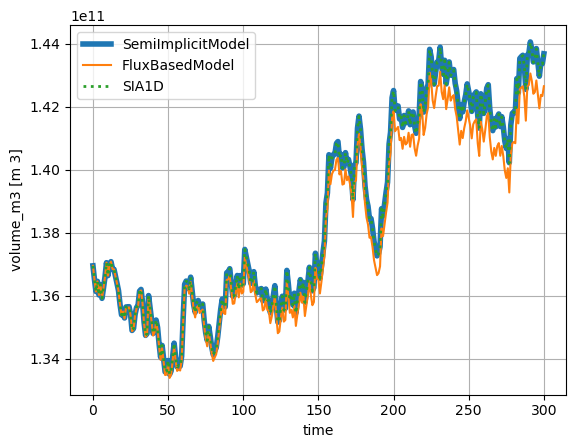

In [19]:
ds_impl_eb.volume_m3.plot(label='SemiImplicitModel', lw=4)
ds_flux_eb.volume_m3.plot(label='FluxBasedModel')
ds_SIA1D_eb.volume_m3.plot(label='SIA1D', linestyle='dotted',lw=2)
plt.legend();
plt.grid()

In [24]:
print('SIA1D: {}s\nSemiImplicit: {}s\nFluxBased: {}s'.format(round(SIA1D_time,2),
                                                             round(semi_implicit_time,2),
                                                             round(flux_based_time,2)))

SIA1D: 0.92s
SemiImplicit: 1.07s
FluxBased: 1.83s


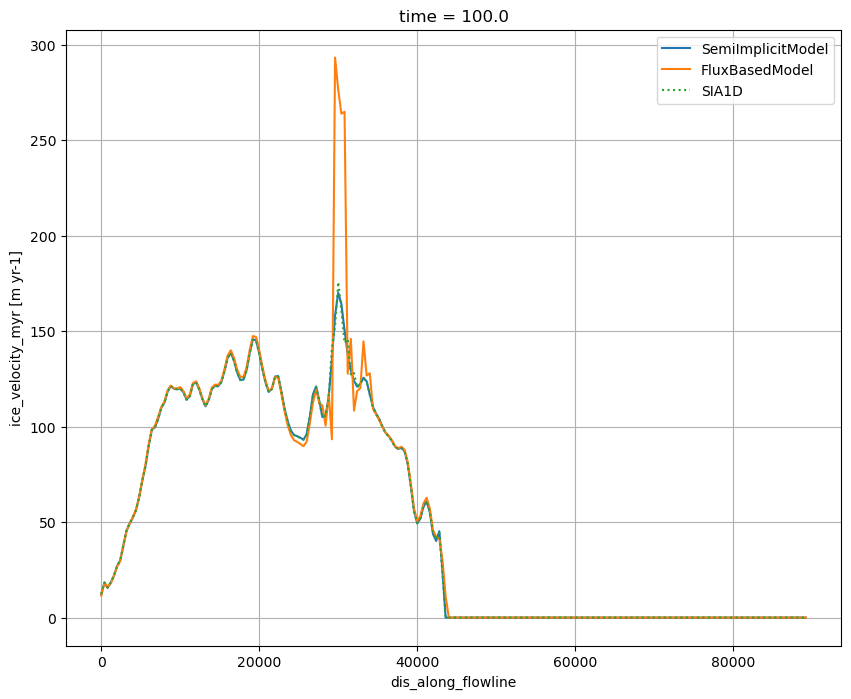

In [32]:
# open flowline diagnostics
f_impl = gdir_eb.get_filepath('fl_diagnostics', filesuffix='_semi_implicit')
f_flux = gdir_eb.get_filepath('fl_diagnostics', filesuffix='_flux_based')
f_sia = gdir_eb.get_filepath('fl_diagnostics', filesuffix='_SIA1D')
with xr.open_dataset(f_impl, group=f'fl_0') as ds:
    ds_fl_impl = ds.load()
with xr.open_dataset(f_flux, group=f'fl_0') as ds:
    ds_fl_flux = ds.load()
with xr.open_dataset(f_sia, group=f'fl_0') as ds:
    ds_fl_sia = ds.load()
    
# compare velocities along flowline
year = 100
plt.subplots(figsize=(10, 8))
ds_fl_impl.sel(time=year).ice_velocity_myr.plot(label='SemiImplicitModel')
ds_fl_flux.sel(time=year).ice_velocity_myr.plot(label='FluxBasedModel')
ds_fl_sia.sel(time=year).ice_velocity_myr.plot(label='SIA1D', linestyle='dotted')
plt.legend();
plt.grid()